In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Данные - ?

### Взял данные отсюда, потому что понравилась формулировка задачи + достаточное количество данных, которое сложно собрать просто руками по очевидным причинам https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

In [ ]:
df = pd.read_csv("marketing_AB.csv",sep=",")
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [ ]:
df.columns[0]

'Unnamed: 0'

In [ ]:
len(df)

588101

In [ ]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()


,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


### user id - User ID (unique);
### test group - Если "ad", то человек увидел рекламу, если "psa", то он увидел только объявление о государственной службе;
### converted - Если человек купил продукт, то это правда, все остальное - ложь;
### total ads - Количество объявлений, просмотренных одним человеком;
### most ads day - День, когда пользователь увидел наибольшее количество объявлений;
### most ads hour - Час, когда пользователь увидел наибольшее количество объявлений;

# Будем определять по converted, насколько хорошо работает реклама, но в начале проделаем некоторую манипуляцию с данными для лучшего понимания

In [ ]:
df.isnull().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

### Пропусков нет, это хорошо

In [18]:
df[df['test group'] == 'ad']['most ads day'].mode()

0    Friday
Name: most ads day, dtype: object

In [19]:
df[df['test group'] == 'psa']['most ads day'].mode()

0    Thursday
Name: most ads day, dtype: object

### Здесь есть небольшая проблема, что самый популярный день, когда было больше всего рекламы для тестовой группы на 1 день позже, но я думаю это не сильно на дизайн эксперимента и на результаты

In [ ]:
df.groupby("test group").agg({"total ads":"mean","most ads hour":"mean"})

,total ads,most ads hour
test group,,
ad,24.823365,14.475900
psa,24.761138,14.304923


### Видно, что разделение качественное и для наших тестовых групп хорошо совпадают другие параметры и нет никаких проблем с сегментами

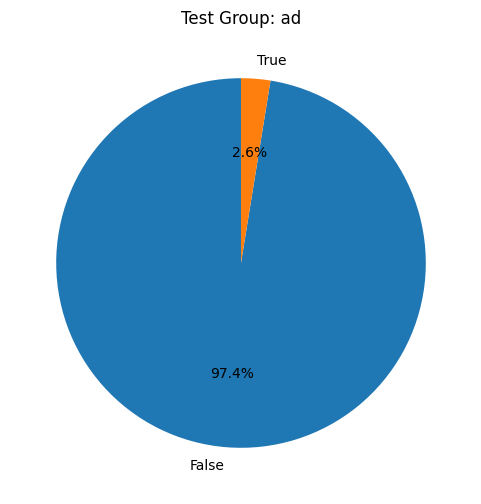

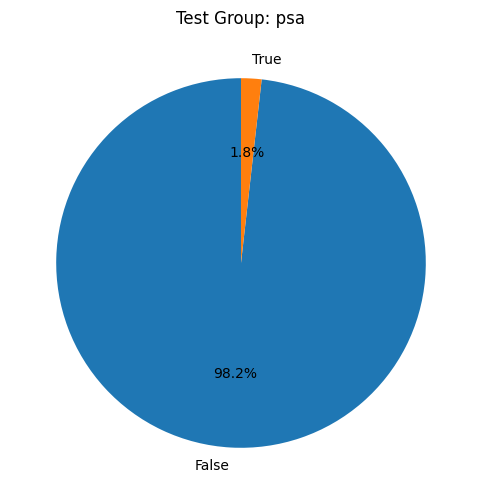

In [ ]:
test_groups = df['test group'].unique()

for group in test_groups:
    group_data = df[df['test group'] == group]

    counts = group_data['converted'].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Test Group: ' + str(group))
    plt.show()

### Здесь видно, что данные немного странные, потому что покупки совершают 2 и 3 процента соответственно от всех покупателей, как будто в реальном мире такая компания уже бы обанкротилась

# Гипотезы:
### H0: Нулевая гипотеза (H0) заключается в том, что между группами нет существенной разницы.
### H1: Альтернативная гипотеза (H1) заключается в том, что тестовая группа (ad - группа) работает значительно лучше.


# Так как у нас конверсия, а это биноминальная метрика, то будем использовать хи-квадрат для анализа конверсии

In [20]:
import statsmodels.stats.proportion as proportion

In [21]:
alpha = 0.05 #возьмем такой уровень значимости

In [22]:
chi2stat, pval, table = proportion.proportions_chisquare(df['converted'],df['user id'])

In [23]:
print(pval < alpha)

False


### Как видно из последней строчки, статистически значимой разницы в конверсии не обнаружено, так как p-value выше выбранного порога ошибки первого рода, значит мы не можем отклонить нулевую гипотезу

### Также можно добавить, что если бы были еще данные по чеку, насколько купили люди. То пришлось бы еще анализировать средний чек. Потому что метрики -  конверсии и средний чек чаще всего имеют разные направления. Когда растет одна, то может падать другая. И по итогу несмотря на то, что количество переходов и покупки улучшились, но эксперимент может оказаться неудачным, так как бизнес по итогу может заработать меньше денег, несмотря на то, что количество покупок увеличилось.